<div style="background-color:#e0f0ff; padding:20px; border-radius:10px;">
  <b style="color:#003366; font-size:2.5em;">Sticky Prices, Shifting Behaviour: Untangling Supply and Demand in U.S. Gasoline Markets</b>
</div>


## **Research Motivation**

Petrol markets exhibit complex interactions between price, supply, and consumer behaviour. This project investigates whether **prices drive consumer behaviour** or if **demand and supply dynamics push prices** — especially in light of **sticky prices** observed in administered markets.


## **Research Questions**

- **Q1:** Does petrol demand (proxied by vehicle miles travelled) respond to changes in petrol prices?
- **Q2:** How does petrol supply (production levels) interact with prices? Is there evidence of supply-driven price shocks?
- **Q3:** Are there seasonal or structural shifts in these relationships over time (e.g., post-2008 or during COVID)?


## **The Theory Behind Our Work**

### A Keynesian View on Sticky Prices

According to Keynesian theory:
- In the **short run**, prices (especially for essential goods like petrol) do not adjust instantaneously.
- Instead, **quantities adjust**, making **behavioural responses (e.g., driving less)** a key margin for equilibrium.
  
This implies that:

> **Petrol price changes → changes in consumer behaviour**, rather than the reverse.

However, real-world markets are noisy:
- **Supply shocks** (e.g., refinery outages, OPEC decisions) may cause **price changes unrelated to demand**.
- **Macroeconomic and behavioural factors** (e.g., seasonal driving, economic cycles) may shift demand and indirectly affect prices.

<div style="border-left: 5px solid #2196F3; background-color: #E3F2FD; padding: 15px; margin-bottom: 20px;">
  <h3><strong>Primary Hypothesis</strong></h3>
  <ul>
    <li><strong>H₀ (Null):</strong> Changes in petrol demand and supply levels cause price fluctuations.</li>
    <li><strong>H₁ (Alternative):</strong> Petrol price changes influence driving behaviour and production levels.</li>
  </ul>
</div>


In [16]:
# Imports
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt

In [2]:
# Import production and consumer data
prices_weekly = pd.read_csv('./data/weekly_gasoline_prices.csv')
supply_weekly = pd.read_csv('./data/weekly_supply_estimates.csv')
transport_monthly = pd.read_csv('./data/monthly_transportation_statistics.csv')

## **0. Data Preprocessing and Exploratory Data Analysis (EDA)**

We utilize the following datasets to examine trends in gasoline pricing, supply-demand dynamics, and transportation behavior. For each dataset, we identify specific variables of interest:

| **Dataset**                          | **Selected Variable**                                                                 | **Descriptions**                  |
|-------------------------------------|----------------------------------------------------------------------------------------|---------------------------------------|
| **Weekly Petrol Prices**            | `Price`                                                                                | Price reported for that week |
| **Weekly Supply Estimates**         | `Weekly U.S. Ending Stocks of Finished Motor Gasoline  (Thousand Barrels)`             | Total production of conventional motor gasoline which is defined as: finished motor gasoline not included in the oxygenated or reformulated gasoline categories                |
| **Monthly Transport Statistics**    | `Highway Vehicle Miles Travelled - All Systems`                                        | The Federal Highway Administration estimates vehicle miles travelled on all roads and streets in each month             |

### **0.1 `prices_weekly`**

We filter the dataset to focus exclusively on retail gasoline prices across all grades and formulations in the United States, then clean up unneeded columns for clarity and ease of analysis.

1. **Filter for gasoline price type**
* Keep only rows where 'Type' is 'All Grades All Formulations Retail Gasoline Prices (Dollars per Gallon)'.

2. **Filter geography**
* Keep only rows where 'Geography' is 'US'.

3. **Drop irrelevant columns**
* Remove 'Type', 'Type_Clean', and 'Unit' columns — these are now redundant.

In [3]:
# Filter for the relevant gasoline price type
prices = prices_weekly.copy()[prices_weekly['Type'] == 'All Grades All Formulations Retail Gasoline Prices  (Dollars per Gallon)']

# Keep only U.S. data
prices = prices[prices['Geography'] == 'US']

# Drop unnecessary columns
prices = prices.drop(columns=['Type', 'Type_Clean', 'Unit', 'Geography', 'Year']).reset_index(drop=True)

# Rename
prices = prices.rename(columns={
    'Date': 'date',
    'Year': 'year',
    'Price': 'price'
})

### **0.2 `supply_weekly`**

In [4]:
supply = supply_weekly.copy()[['Date', 'Weekly U.S. Ending Stocks of Finished Motor Gasoline  (Thousand Barrels)']]
supply = supply.rename(columns={
    'Date': 'date',
    'Weekly U.S. Ending Stocks of Finished Motor Gasoline  (Thousand Barrels)': 'motor_gasoline_barrels'
})

#### **Rationale for Using Weekly U.S. Ending Stocks of Finished Motor Gasoline as a Proxy for Supply and Demand**

The variable **`Weekly U.S. Ending Stocks of Finished Motor Gasoline (Thousand Barrels)`** represents the total inventory of conventional motor gasoline held in stock at the end of each week. This measure reflects the **finished motor gasoline** that is **not included in oxygenated or reformulated gasoline categories**, focusing solely on conventional gasoline production.

As such, it serves as a reliable **proxy for gasoline supply** for several reasons:

- **Inventory Levels Represent Supply Availability:** Ending stocks indicate how much gasoline is physically available in the market after production, imports, and consumption within the week.
- **Conventional Gasoline Focus:** By isolating finished conventional motor gasoline, this measure avoids complications from alternative fuel blends, providing a clearer view of mainstream gasoline supply.
- **Market Balancing Act:** Changes in ending stocks reflect the balance between supply and demand; when stocks decline, it often signals higher consumer demand relative to production, and vice versa.

While this variable primarily measures supply, it also **indirectly captures consumer demand dynamics**:

- **Demand Reduces Stocks:** Higher consumption by consumers reduces the inventory of finished motor gasoline, causing ending stocks to fall.
- **Supply-Demand Interaction:** Thus, weekly fluctuations in ending stocks embody the net effect of production and consumer usage, making it a practical, observable proxy that links supply with real-time demand pressure in the market.

In summary, by tracking **Weekly U.S. Ending Stocks of Finished Motor Gasoline**, we capture a vital indicator of gasoline availability and consumption behaviour, enabling insightful analysis of supply-demand trends in the U.S. gasoline market.

### **0.3 `transport`**

In [5]:
demand = transport_monthly.copy()[['Date', 'Highway Vehicle Miles Traveled - All Systems']].copy()
demand = demand.rename(columns={
    'Date': 'date',
    'Highway Vehicle Miles Traveled - All Systems': 'miles_travelled'
})

### **0.4 Overall EDA**

#### **Visualising missing data**

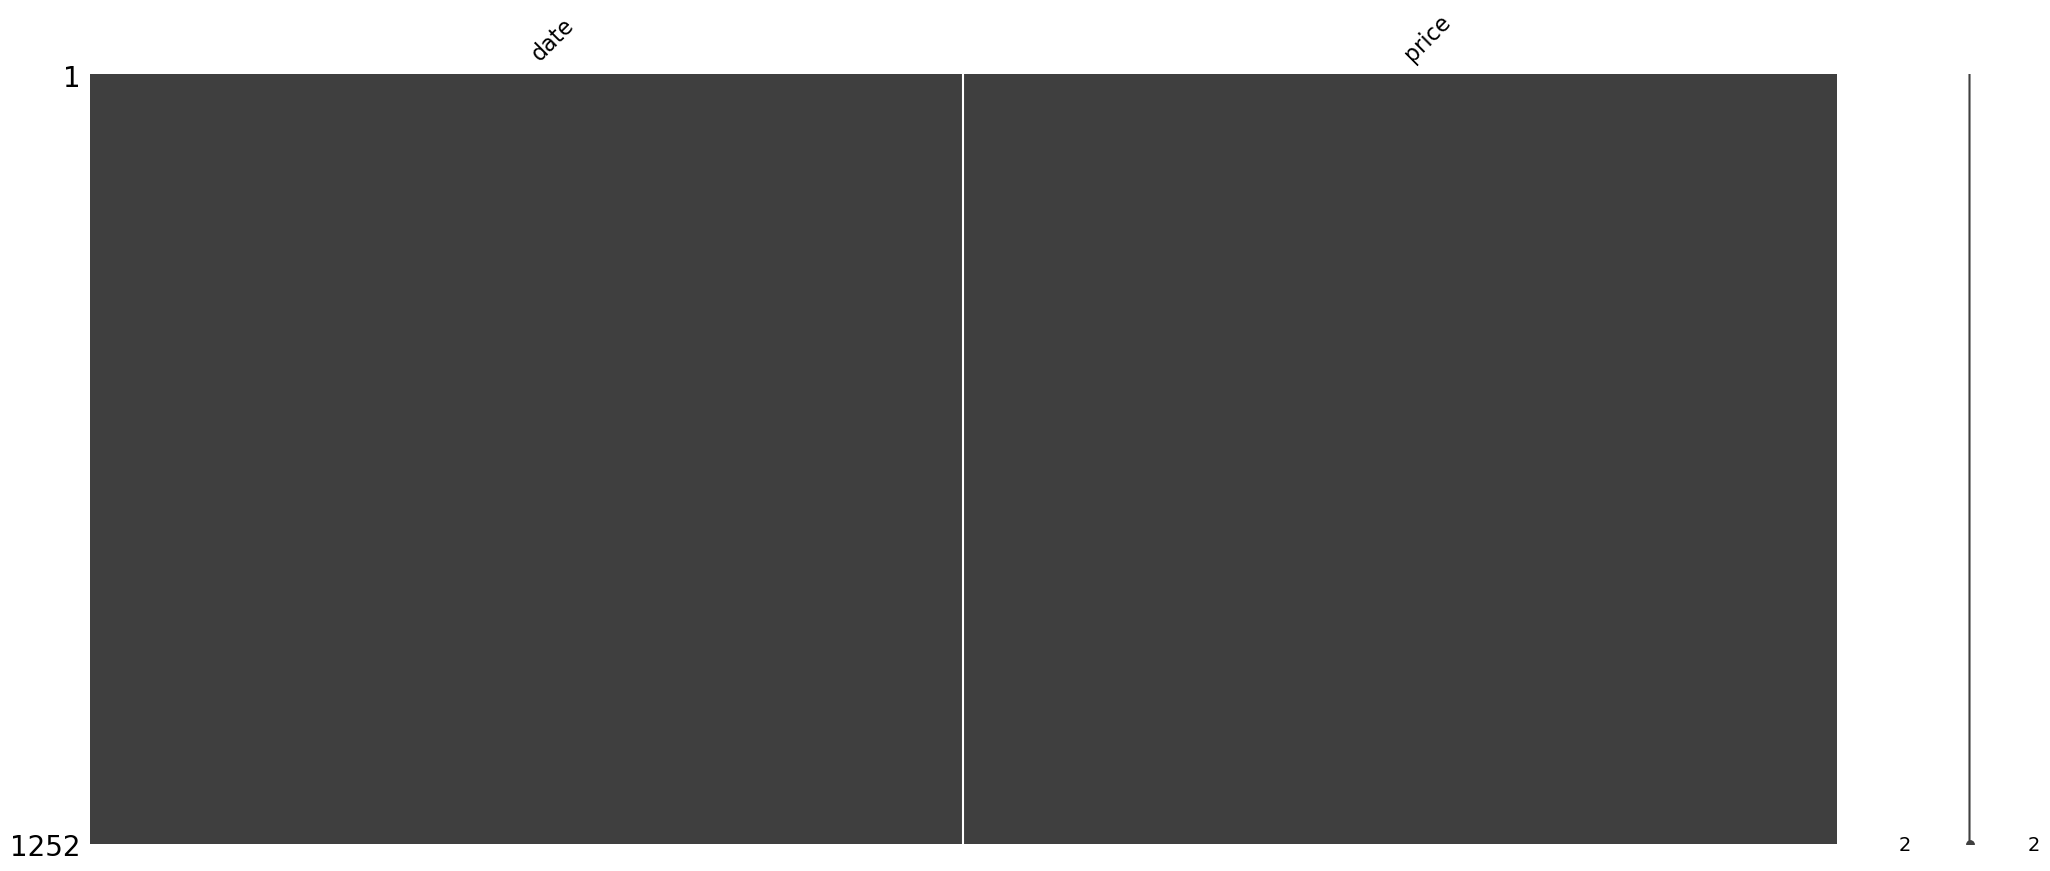

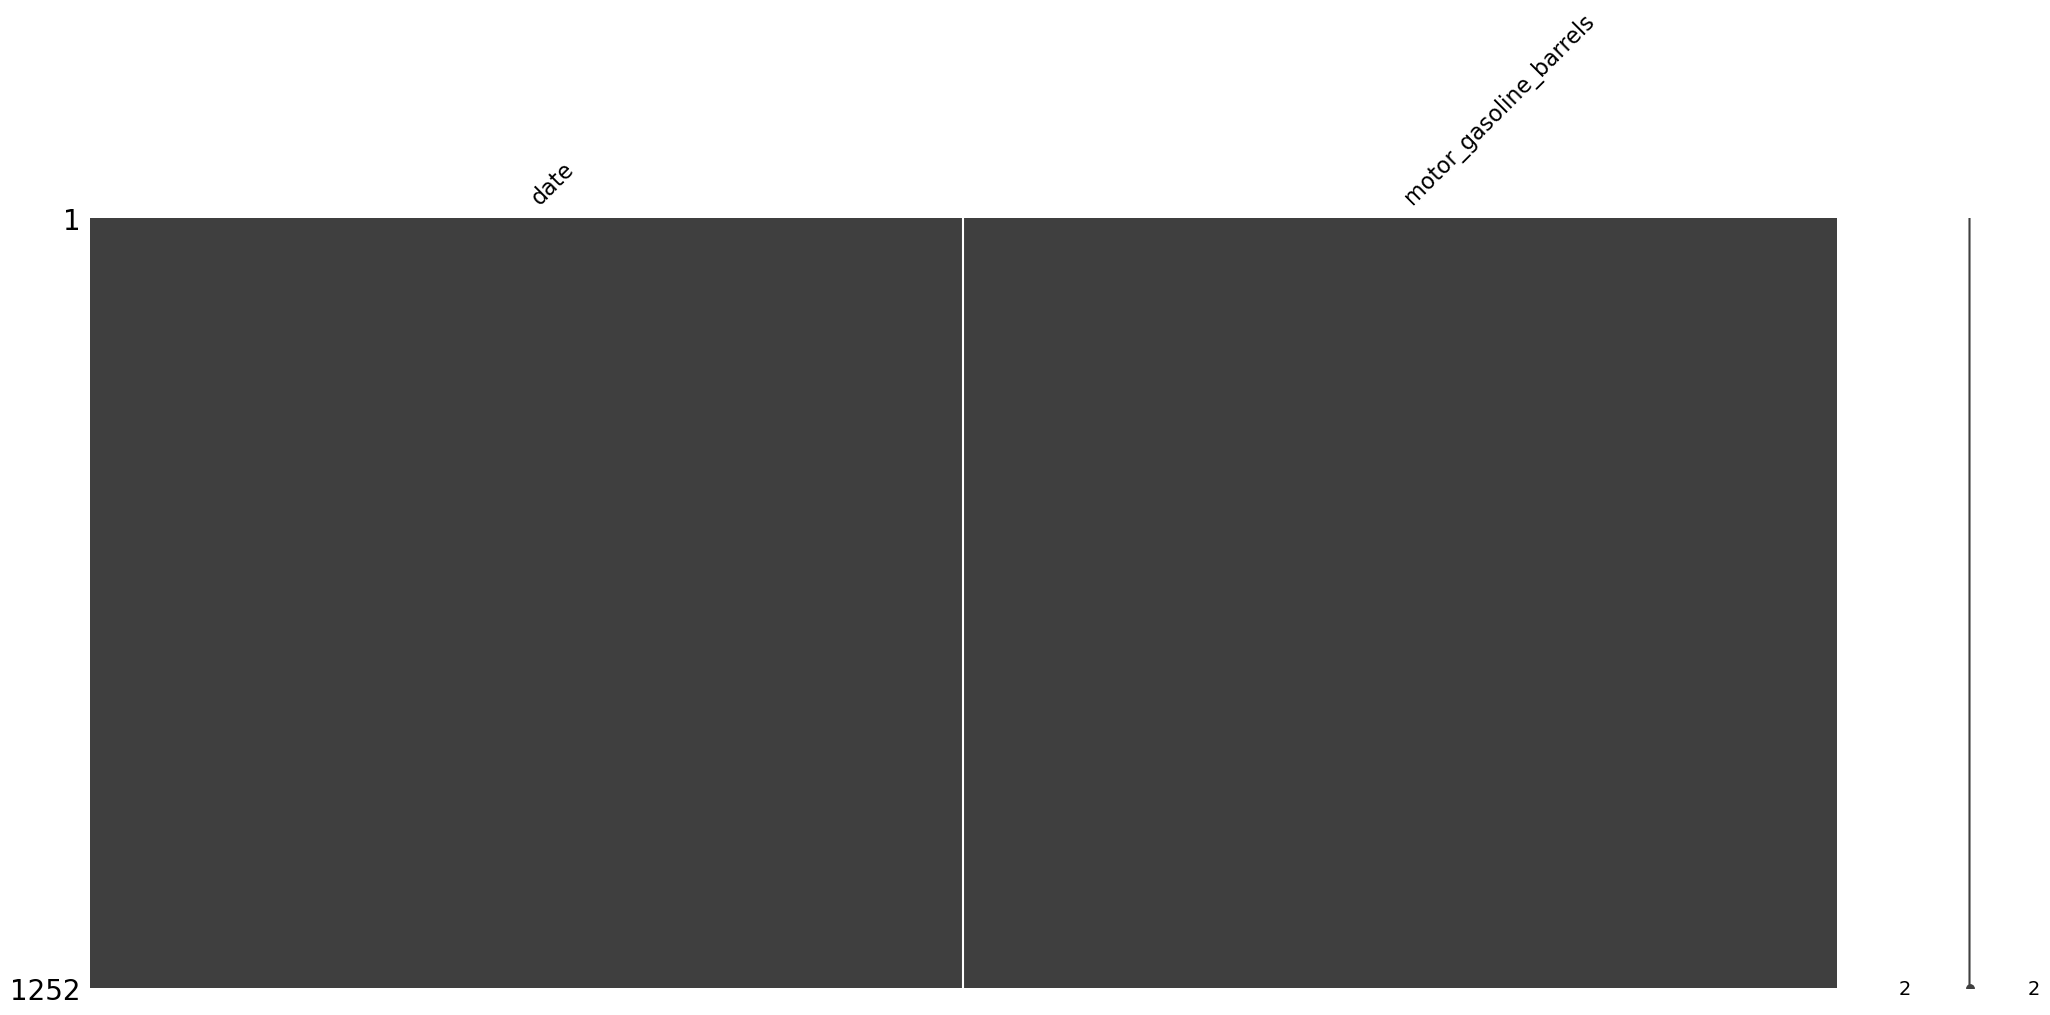

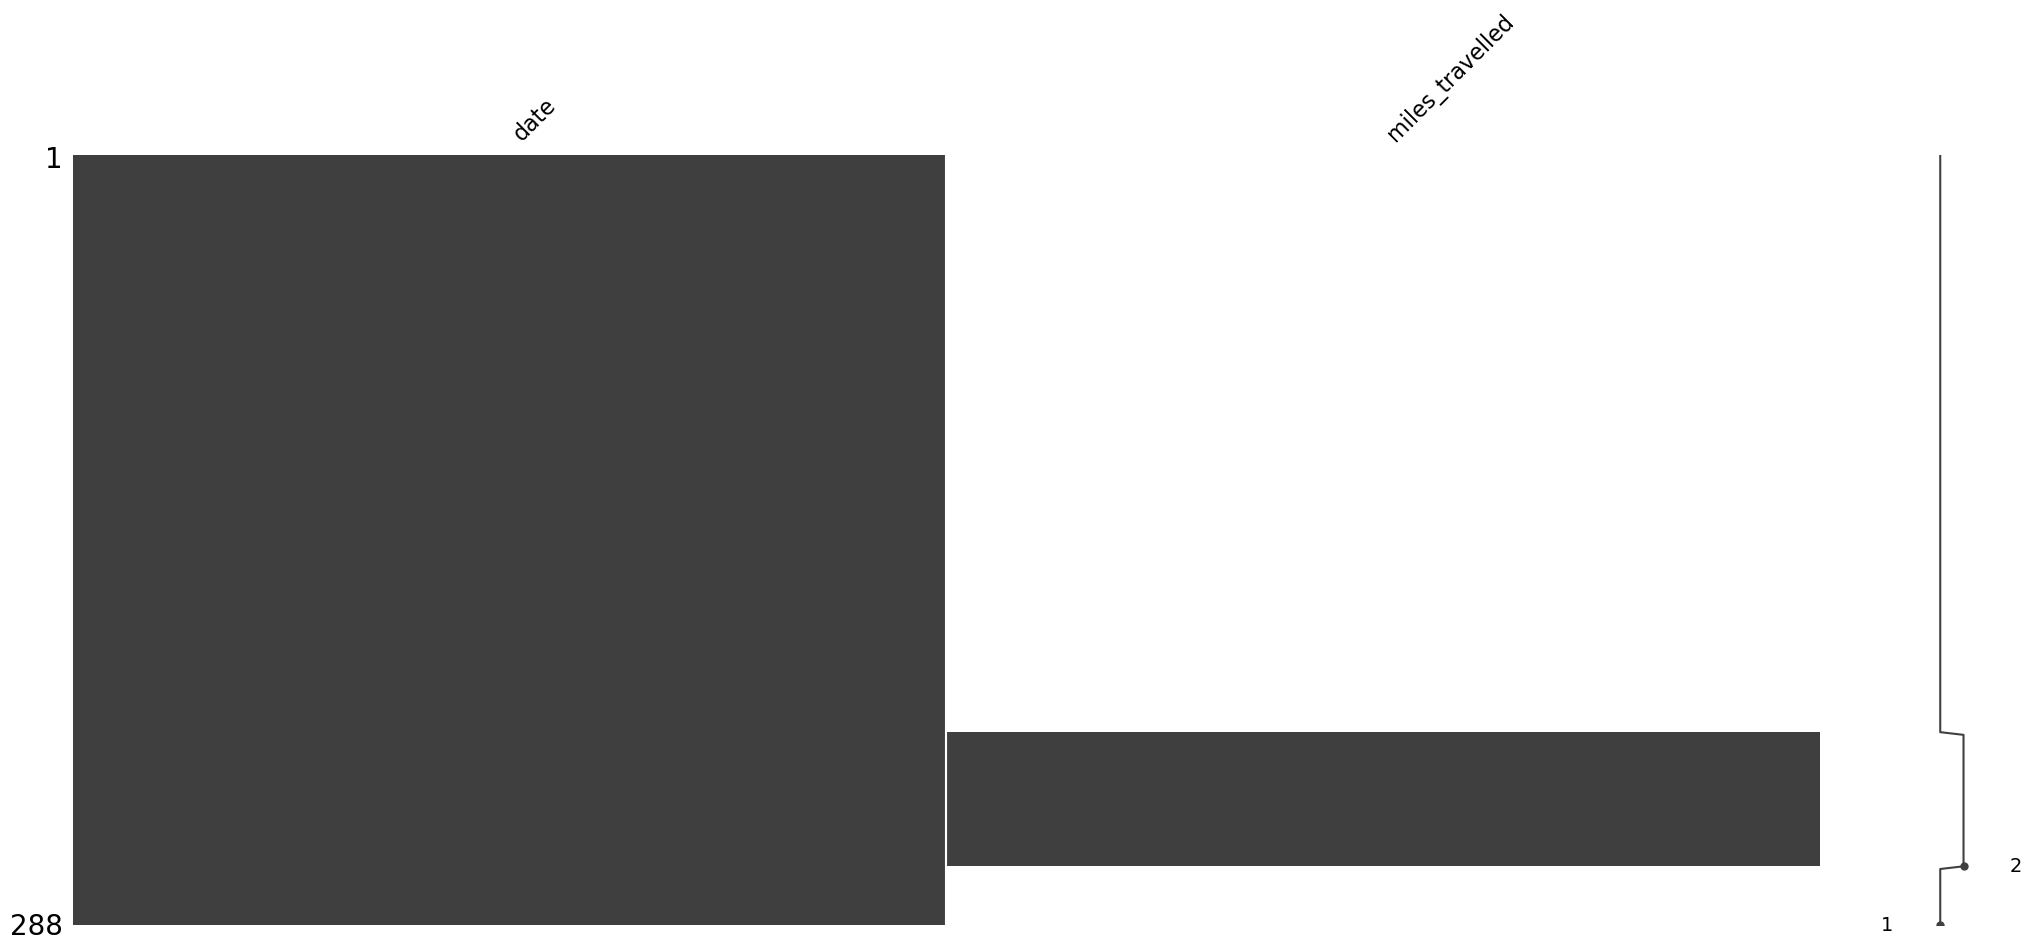

In [6]:
for df in [prices, supply, demand]:
    msno.matrix(df)
    plt.show()

In [7]:
# Drop NaNs in 'miles_travelled' and work on a copy to avoid SettingWithCopyWarning
demand = demand.dropna(subset=['miles_travelled']).copy()

# Convert 'date' to datetime
demand['date'] = pd.to_datetime(demand['date'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')

# Drop rows where datetime conversion failed
demand = demand.dropna(subset=['date'])

# Get min and max dates
start_date = demand['date'].min()
end_date = demand['date'].max()
start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')

print(f"Date range of demand: {start_date_str} to {end_date_str}")

# Format date column to "YYYY-MM-DD"
demand['date'] = demand['date'].dt.strftime('%Y-%m-%d')

# Reset index
demand = demand.reset_index(drop=True)

Date range of demand: 2018-01-01 to 2022-02-01


In [8]:
# Convert date columns to datetime
prices['date'] = pd.to_datetime(prices['date'])
supply['date'] = pd.to_datetime(supply['date'])

# Define date range
start_date = '2018-01-01'
end_date = '2022-12-31'

# Filter both DataFrames by the date range
prices = prices[(prices['date'] >= start_date) & (prices['date'] <= end_date)].reset_index(drop=True)
supply = supply[(supply['date'] >= start_date) & (supply['date'] <= end_date)].reset_index(drop=True)

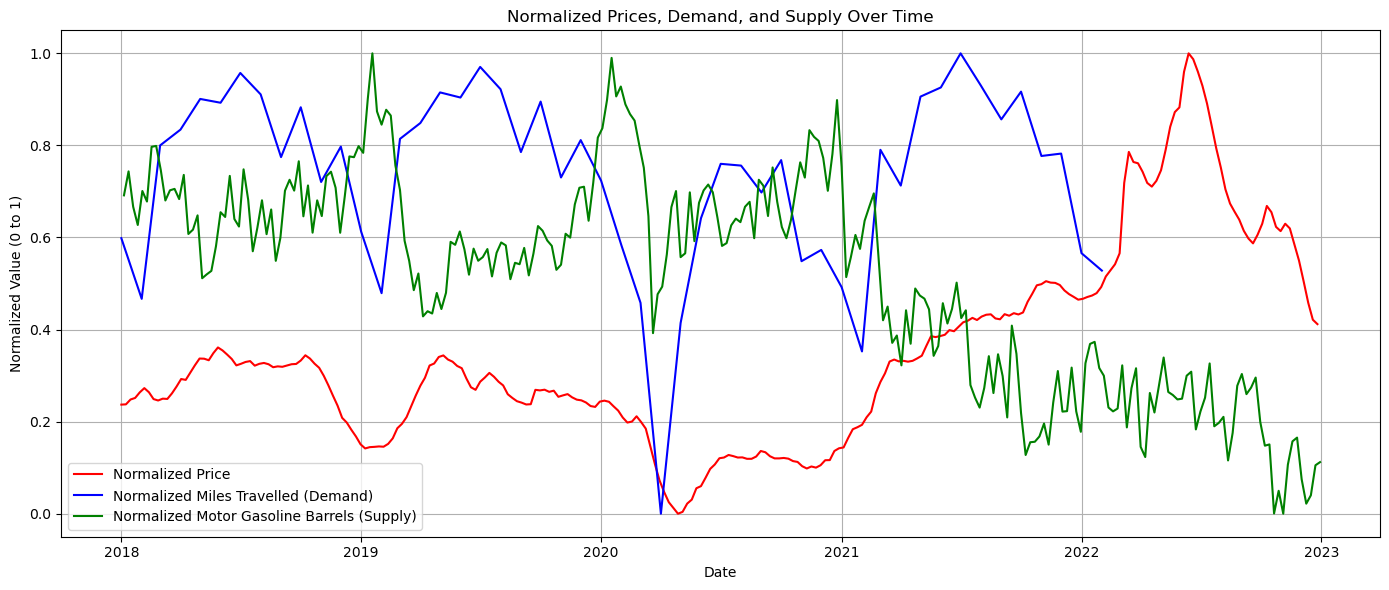

In [15]:
def normalize(series):
    return (series - series.min()) / (series.max() - series.min())

# Apply normalization
prices['price_norm'] = normalize(prices['price'])
demand['miles_travelled_norm'] = normalize(demand['miles_travelled'])
supply['motor_gasoline_barrels_norm'] = normalize(supply['motor_gasoline_barrels'])

plt.figure(figsize=(14, 6))

plt.plot(prices['date'], prices['price_norm'], label='Normalized Price', color='red')
plt.plot(demand['date'], demand['miles_travelled_norm'], label='Normalized Miles Travelled (Demand)', color='blue')
plt.plot(supply['date'], supply['motor_gasoline_barrels_norm'], label='Normalized Motor Gasoline Barrels (Supply)', color='green')

plt.xlabel('Date')
plt.ylabel('Normalized Value (0 to 1)')
plt.title('Normalized Prices, Demand, and Supply Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### **4.1 Trend and Seasonal Analysis**
- Decompose all three time series (using rolling averages or STL decomposition).
- Identify seasonal patterns: e.g., do prices spike during summer? Does driving decline during winter?

### **4.2 Correlation and Lag Analysis**
- Use **cross-correlation functions** (CCF) to identify whether prices **lead** or **lag** demand and supply.
- Apply **Granger causality tests** to assess directionality:
  - Does `Price → VMT` (supporting sticky price theory)?
  - Or does `VMT → Price` (demand-driven pricing)?

### **4.3 Structural Breaks and Shocks**
- Identify known exogenous shocks (e.g., COVID-19, 2008 crisis, Ukraine war).
- Use **dummy variables or rolling regressions** to examine how relationships shift during these periods.

## **6. Potential Extensions**

- **Asymmetric Effects**: Do rising prices have a stronger impact on driving behaviour than falling prices?
- **Elasticity Estimates**: Estimate the short-run vs. long-run price elasticity of petrol demand.
- **Policy Implications**: Explore how fiscal policy (e.g. stimulus payments) or regulation (e.g. fuel duties) interacts with consumer behaviour and pricing.